# Approximate $\tau_0$ and scale the burst drift

$ \tau_0 \simeq \frac{b}{\cos\theta} $ Where $b$ is the minor axis of the gaussian fit to the burst autocorrelation.
Then, if $d\nu_{\text{obs}} / dt_{\text{obs}}$ is the burst drift, we expect 


### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}}=\frac{\nu_{\text{obs}}^{2}}{\nu_{0}\tau_{0}}\simeq\frac{\nu_{\text{obs}}^{2}b}{\nu_{0}\cos\theta}$

In [1]:
import numpy as np
import scipy.stats
import scipy.odr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from tqdm import tqdm
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd

bursts121102 = pd.read_csv('../bursts.csv')
bursts121102 = bursts121102.set_index('name')

##########
bursts180916 = pd.merge(pd.read_csv('data/CHIME_180916.J0158+65/chime_180916_fit_params_real.csv'),
                        pd.read_csv('data/CHIME_180916.J0158+65/chime_180916_param_errors_real.csv'),
                        how='left', on='name')
bursts180916 = bursts180916.set_index('name')

#########
params180916 = ['data/CHIME_180916.J0158+65/chime_180916_fit_params_real.csv',
          'data/CHIME_180916.J0158+65/chime_180916_fit_params_ddm1.csv',
          'data/CHIME_180916.J0158+65/chime_180916_fit_params_ddm2.csv',
          'data/CHIME_180916.J0158+65/chime_180916_fit_params_ddm-half.csv']

paramerrs180916 = ['data/CHIME_180916.J0158+65/chime_180916_param_errors_real.csv',
             'data/CHIME_180916.J0158+65/chime_180916_param_errors_ddm1.csv',
             'data/CHIME_180916.J0158+65/chime_180916_param_errors_ddm2.csv',
             'data/CHIME_180916.J0158+65/chime_180916_param_errors_ddm-half.csv']

dataframes180916 = []
for param, paramerr in zip(params180916, paramerrs180916):
    frame = pd.merge(pd.read_csv(param),
                     pd.read_csv(paramerr),
                     how='left', on='name')
    frame = frame.set_index('name')
    dataframes180916.append(frame)

#########

#########
bursts180814 = pd.merge(pd.read_csv('data/CHIME_FRB180814.J0422+73/chime_180814_img_fit_params.csv'),
                        pd.read_csv('data/CHIME_FRB180814.J0422+73/chime_180814_img_param_errors.csv'),
                        how='left', on='name')
bursts180814 = bursts180814.set_index('name')


# Correct sigmax and sigmay for pixel scale
bursts180814['sigmax'] = bursts180814[['sigmaxp', 'xscale']].apply(lambda row: abs(row['sigmaxp'])/row['xscale'], axis=1)
bursts180814['sigmay'] = bursts180814[['sigmayp', 'yscale']].apply(lambda row: abs(row['sigmayp'])/row['yscale'], axis=1)
bursts180814['sigmax_error'] = bursts180814[['sigmaxp_error', 'xscale']].apply(lambda row: abs(row['sigmaxp_error'])/row['xscale'], axis=1)
bursts180814['sigmay_error'] = bursts180814[['sigmayp_error', 'yscale']].apply(lambda row: abs(row['sigmayp_error'])/row['yscale'], axis=1)

# Set redshifts
bursts121102['z'] = 0.19273 # (josephy et al. 2019, frbcat.org)
bursts180916['z'] = 0.0337  # (chime 2020b et al.)
bursts180814['z'] = 0.05    # not accurate, z < 0.1 (amiri et al. 2019)
for frame in dataframes180916:
    frame['z'] = 0.337

# bursts121102
bursts180814

,amplitude,xo,yo,sigmaxp,sigmayp,theta,drift (mhz/ms),angle,xscale,yscale,...,sigmaxp_error,sigmayp_error,angle_error,drift error (mhz/ms),red_chisq,sigmax,sigmay,sigmax_error,sigmay_error,z
name,,,,,,,,,,,,,,,,,,,,,
burst180814,170.460929,348.482341,650.515381,13.423814,86.414958,-9.544872,-13.994177,11.115669,2.697674,10.15625,...,0.009794,0.063051,0.000164,0.019321,7.935805,4.976069,8.508550,0.003630,0.006208,0.05
burst180911,161.775841,348.475970,650.475781,11.509405,51.025758,-9.455869,-54.298078,11.026666,2.697674,10.15625,...,0.008604,0.038134,0.000251,0.439138,8.177593,4.266417,5.024075,0.003189,0.003755,0.05
burst180917,114.783963,348.498284,650.523744,25.229454,166.514516,-9.645794,-3.758155,11.216591,2.697674,10.15625,...,0.005132,0.033874,0.000045,0.000784,11.837501,9.352298,16.395275,0.001903,0.003335,0.05
burst180919,124.668419,348.473626,650.485046,19.671831,38.082662,-9.370266,30.948518,10.941062,2.697674,10.15625,...,0.021844,0.042295,0.001106,0.629375,7.448608,7.292144,3.749677,0.008097,0.004164,0.05
burst181028,422.907745,348.498487,650.512116,26.454510,-74.532726,-9.835755,-5.852370,11.406551,1.359375,10.15625,...,0.003260,0.009184,0.000071,0.001131,11.809635,19.460789,7.338607,0.002398,0.000904,0.05


## Compute 121102 details

Text(0.5, 0, 'Burst #')

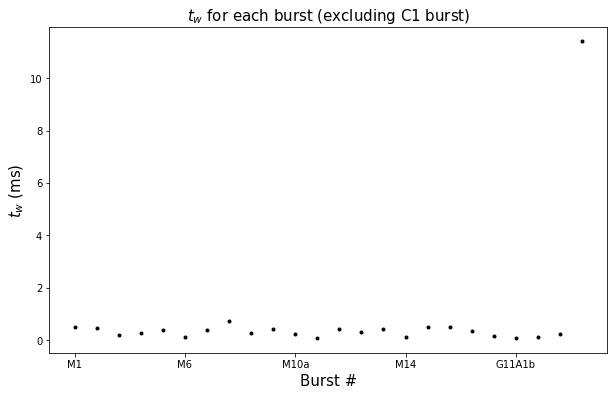

In [2]:
bursts121102['drift_abs'] = abs(bursts121102['drift (mhz/ms)'])
bursts121102['drift_over_nuobs'] = bursts121102[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts121102['min_sigma'] = bursts121102[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts121102['max_sigma'] = bursts121102[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)

# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts121102['min_sigma_error'] = bursts121102[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts121102['max_sigma_error'] = bursts121102[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts121102['sigma_t']   = bursts121102[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts121102['tau_w'] = bursts121102[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts121102['tau_w_error'] = bursts121102[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts121102['sigma_t_ms'] = bursts121102['sigma_t']*1e3
bursts121102['tau_w_ms'] = bursts121102['tau_w']*1e3

## C1 
bursts121102.at['C1', 'tau_w_ms'] = 11.4
bursts121102.at['C1', 'tau_w'] = 11.4/1000
bursts121102.at['C1', 'tau_w_error'] = 0.12

## Redshift corrections
bursts121102['drift_z'] = bursts121102[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts121102['tau_w_ms_z'] = bursts121102[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)

bursts121102_to_include = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9a', 'M9b', 'M10a', 'M10b', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'G11D', 'G11A1a', 'G11A1b', 'G11A2', 'G11A3', 'C1']
fontsize=15

selectbursts121102 = bursts121102.loc[bursts121102_to_include]
ax = selectbursts121102['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ for each burst (excluding C1 burst)", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')

## Compute 180916 details

Text(0.5, 0, 'Burst #')

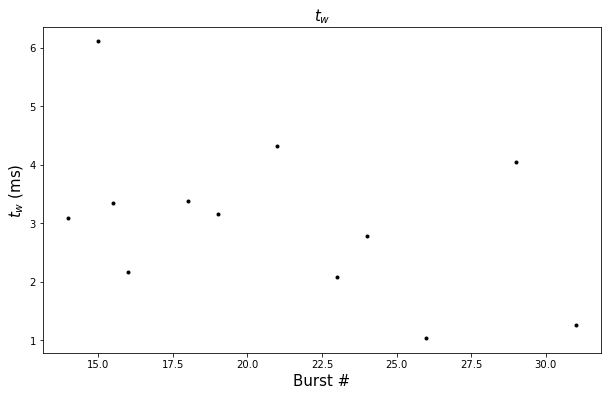

In [3]:
bursts180916['drift_abs'] = abs(bursts180916['drift (mhz/ms)'])
bursts180916['drift_over_nuobs'] = bursts180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts180916['min_sigma'] = bursts180916[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts180916['max_sigma'] = bursts180916[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts180916['min_sigma_error'] = bursts180916[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts180916['max_sigma_error'] = bursts180916[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts180916['sigma_t']   = bursts180916[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts180916['tau_w'] = bursts180916[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts180916['tau_w_error'] = bursts180916[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts180916['sigma_t_ms'] = bursts180916['sigma_t']*1e3
bursts180916['tau_w_ms'] = bursts180916['tau_w']*1e3

## Redshift corrections
bursts180916['drift_z'] = bursts180916[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts180916['tau_w_ms_z'] = bursts180916[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)

fontsize=15

# selectbursts180916 = bursts180916
selectbursts180916 = bursts180916.loc[[x for x in bursts180916.index if x not in [13, 32, 33, 36]]]
ax = selectbursts180916['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ ", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')
# selectbursts180916[['tau_w_ms', 'tau_w_error']]

## Compute 180916 Trial DM details

In [78]:
dataframes180916[3]

,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle,time_res,center_f,...,min_sigma_error,max_sigma_error,sigma_t,tau_w,tau_w_error,sigma_t_ms,tau_w_ms,drift_z,tau_w_ms_z,angle_clean
name,,,,,,,,,,,,,,,,,,,,,
13.0,200.000000,80.390680,64.434638,12.848243,1.754267,1.569881,6946.838781,1.569231,0.000983,600,...,0.075341,0.551794,0.001725,0.001725,0.542400,1.724515,1.724517,15.479872,1.289840,-0.001565
14.0,649.314367,80.375611,64.411376,8.420559,-2.710737,2.143134,-9.868245,2.143134,0.000983,600,...,0.053428,0.165959,0.002665,0.003104,0.086748,2.664763,3.103877,0.021990,2.321524,0.572338
15.0,97.807011,140.390833,64.252208,11.206269,5.237657,1.853201,-21.911463,1.836163,0.000983,600,...,0.038669,0.082734,0.005149,0.005293,0.072859,5.148827,5.293060,0.048826,3.958908,0.265366
15.5,506.557763,176.380357,64.343676,3.425176,8.370467,0.500237,-11.631378,-1.070559,0.000983,600,...,0.036451,0.089080,0.003367,0.003745,0.059807,3.367085,3.744740,0.025919,2.800852,0.500237
16.0,449.010463,80.286198,64.131362,2.356481,4.773796,0.252045,-24.688582,-1.318752,0.000983,600,...,0.065738,0.133173,0.002317,0.002373,0.119856,2.316515,2.372998,0.055014,1.774868,0.252045
18.0,2681.366250,80.466977,64.406987,13.647895,3.380344,1.800886,-27.142600,1.800886,0.000983,600,...,0.044356,0.179081,0.003323,0.003407,0.131369,3.323013,3.407229,0.060483,2.548414,0.230090
19.0,1281.046031,80.371761,64.329168,8.276806,2.740718,2.130530,-10.146908,2.130530,0.000983,600,...,0.052415,0.158289,0.002694,0.003113,0.085803,2.694235,3.113125,0.022611,2.328441,0.559733
21.0,311.594880,80.290908,64.328803,8.114973,-4.218965,1.942805,-16.294772,1.942805,0.000983,600,...,0.095364,0.183444,0.004147,0.004363,0.154801,4.147412,4.363065,0.036310,3.263324,0.372009
23.0,4203.404890,80.480024,64.028555,13.507572,2.111249,1.731032,-39.337882,1.731032,0.000983,600,...,0.027084,0.173278,0.002075,0.002102,0.119954,2.075443,2.101704,0.087658,1.571955,0.160235


In [5]:
# ddm = -1/2, 0, 1, 2
for idx in dataframes180916[0].index:
    print(idx, dataframes180916[3]['angle'].loc[idx],  dataframes180916[0]['angle'].loc[idx], dataframes180916[1]['angle'].loc[idx], dataframes180916[2]['angle'].loc[idx])

13.0 1.56923145023643 1.7895401477745403 2.1778088471057 2.4622399246096
14.0 2.1431339269322 2.18054491938041 2.2900157894396203 2.36920832774461
15.0 1.83616256539886 2.0624802181155197 2.33146424099385 2.51345318203208
15.5 -1.07055945557664 -1.0641649109196298 2.1248930658297 2.160169716233
16.0 -1.3187516839525801 -1.28296895366607 -1.1254246657350901 -0.9878969840018641
18.0 1.80088606261589 1.9429303518308798 2.16695945007319 2.3371006872543303
19.0 2.13052952922769 2.16971530249423 2.28145525765378 2.3707571831269303
21.0 1.94280514595308 -0.987329379897119 -0.698912339473743 -0.523404507907316
23.0 1.7310317488459799 1.8145248965487701 1.9870168083817499 2.14051381922248
24.0 70.9278809674219 1.95186533897789 2.08993934477435 2.31925220627466
26.0 4.92388762629525 1.8905014181881599 2.06126642220101 2.21715451851161
29.0 2.0994630987796 2.19042571517757 2.30258300868148 2.39282027201094
31.0 1.6006284796449899 1.71951305497826 1.96081990152743 2.16987025865843
32.0 1.674685826

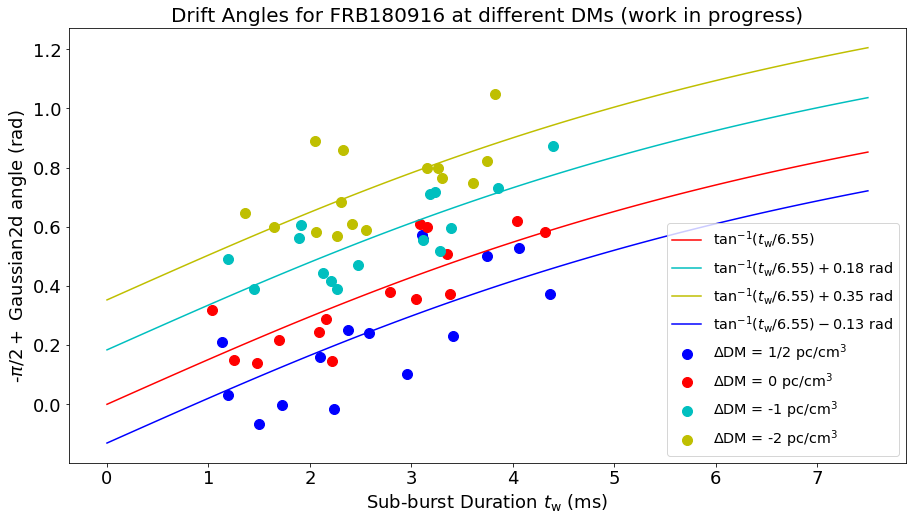

In [114]:
def cleanAngle(row):
    angle = row['angle']
    if angle < 0 or angle > np.pi:
        if angle > np.pi:
            return angle % (np.pi)
        elif angle < 0 and angle > -np.pi:
            return angle + np.pi
        elif angle < 0 and angle < -np.pi:
            angle = angle % (2*np.pi)
            if angle > np.pi:
                return angle - np.pi
            else:
                return angle
    else:
        return angle

def atanmodel(B, x):
    return np.arctan(x/B[0])

zero_ddm_fit = 6.554218399099785
def offset_atanmodel(B, x):
    return np.arctan(x/zero_ddm_fit) + B[0]

thetamodel = scipy.odr.Model(atanmodel)
offsetmodel = scipy.odr.Model(offset_atanmodel)

for dataframe180916 in dataframes180916:
    dataframe180916['drift_abs'] = abs(dataframe180916['drift (mhz/ms)'])
    dataframe180916['drift_over_nuobs'] = dataframe180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
    dataframe180916['min_sigma'] = dataframe180916[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
    dataframe180916['max_sigma'] = dataframe180916[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
    # the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
    dataframe180916['min_sigma_error'] = dataframe180916[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
    dataframe180916['max_sigma_error'] = dataframe180916[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

    dataframe180916['sigma_t']   = dataframe180916[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

    dataframe180916['tau_w'] = dataframe180916[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
        lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
        axis=1
    )

    # this error is in ms
    dataframe180916['tau_w_error'] = dataframe180916[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
        lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
        axis=1
    )

    dataframe180916['sigma_t_ms'] = dataframe180916['sigma_t']*1e3
    dataframe180916['tau_w_ms'] = dataframe180916['tau_w']*1e3

    ## Redshift corrections
    dataframe180916['drift_z'] = dataframe180916[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
    dataframe180916['tau_w_ms_z'] = dataframe180916[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)
    
    ## angle clean (0, pi)
    # dataframe180916['angle_clean'] = (np.pi/2) - dataframe180916[['angle']].apply(cleanAngle, axis=1) 
    dataframe180916['angle_clean'] = dataframe180916[['angle']].apply(cleanAngle, axis=1) - (np.pi/2)
    # dataframe180916['angle_clean'] = (3*np.pi/2) - dataframe180916[['angle']].apply(cleanAngle, axis=1) 

markersize = 100
fontsize = 18
annotsize = 14
logscale = False
figsize = (15, 8)
ax = dataframes180916[3].drop([15]).plot.scatter(x='tau_w_ms', y='angle_clean', 
                               figsize=figsize, s=markersize, c='b', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='$\Delta$DM = 1/2 pc/cm$^3$')

for frame, c, label in zip(dataframes180916[:3], ['r', 'c', 'y'], ['$\Delta$DM = 0 pc/cm$^3$', '$\Delta$DM = -1 pc/cm$^3$', '$\Delta$DM = -2 pc/cm$^3$']):
    frame.drop([15]).plot.scatter(ax=ax, x='tau_w_ms', y='angle_clean', 
                               figsize=figsize, s=markersize, c=c, colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label=label)

ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('-$\pi/2 + $ Gaussian2d angle (rad)', size=fontsize)

## Find Fits
for dataframe180916, drops, pcol, beta in zip(dataframes180916, [[15], [15], [15], [15]], ['r', 'c', 'y', 'b'], [-6, -4, -3, -9]):
    if dataframe180916.equals(dataframes180916[0]):        
        model = thetamodel
    else:
        model = offsetmodel
    
    datafitter = scipy.odr.RealData(dataframe180916.drop(drops)['tau_w_ms'], 
                                 dataframe180916.drop(drops)['angle_clean'])
    anglefitter = scipy.odr.ODR(datafitter, model, beta0=[1])
    anglefitter.set_job(fit_type=0)
    anglefit = anglefitter.run()
    
    tws = np.linspace(0, 7.5, num=80)
    #print(anglefit.beta[0])
    if model == thetamodel:
        plt.plot(tws, np.arctan(tws/anglefit.beta[0]), c=pcol, label="$\\tan^{{-1}}(t_\\mathrm{{w}}/{:.2f})$".format(anglefit.beta[0]))
    elif model == offsetmodel:
        plt.plot(tws, np.arctan(tws/zero_ddm_fit) + anglefit.beta[0], c=pcol, label="$\\tan^{{-1}}(t_\\mathrm{{w}}/{:.2f}) {:+.2f}$ rad".format(zero_ddm_fit, anglefit.beta[0]) )

## Check fits assuming additionl DM produces rotation
time_res = 0.98304 # ms
freq_res = 6.25 # MHz
burstbandwidth = 250 # MHz, roughly
ddms = [1/2, -1, -2] # pc/cm^3
DM = 348.82  # pc/cm^3
nu_high, nu_low = 800, 400 # MHz
for ddm in ddms:
    deltat = 4.14937759336e6 * (nu_low**-2 - nu_high**-2) * ddm
    dtheta = np.arctan(np.tan(dataframes180916[3]['angle_clean']) - (deltat / burstbandwidth) * (freq_res/time_res) * (ddm / DM))
    
## Point Annotations
# for k, v in dataframes180916[3].iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in dataframes180916[0].drop([15]).iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in dataframes180916[0].iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['angle_clean']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
    
# ax.set_xlim(0, 10)
plt.title("Drift Angles for FRB180916 at different DMs (work in progress)", size=20)
plt.legend(fontsize='x-large')
plt.savefig('angleatdifferentDMs.png')
plt.savefig('angleatdifferentDMs.pdf')

## Compute 180814 Details

Text(0.5, 0, 'Burst #')

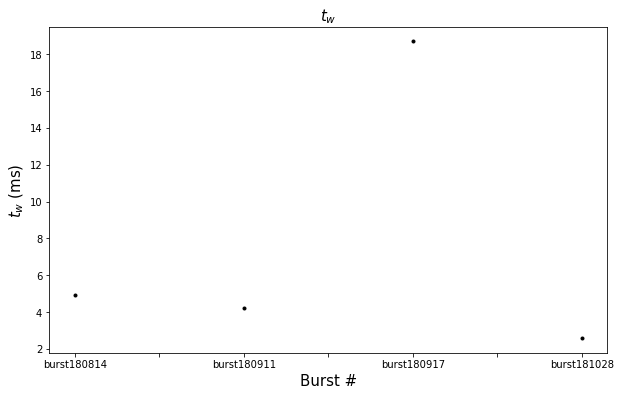

In [4]:
# bursts180814['drift_abs'] = abs(bursts180814['drift (mhz/ms)'])
bursts180814['drift_abs'] = -1*bursts180814['drift (mhz/ms)']
bursts180814['drift_over_nuobs'] = bursts180814[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts180814['min_sigma'] = bursts180814[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts180814['max_sigma'] = bursts180814[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts180814['min_sigma_error'] = bursts180814[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts180814['max_sigma_error'] = bursts180814[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts180814['sigma_t']   = bursts180814[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts180814['tau_w'] = bursts180814[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts180814['tau_w_error'] = bursts180814[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts180814['sigma_t_ms'] = bursts180814['sigma_t']*1e3
bursts180814['tau_w_ms'] = bursts180814['tau_w']*1e3

## Redshift corrections
bursts180814['drift_z'] = bursts180814[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts180814['tau_w_ms_z'] = bursts180814[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)


fontsize=15

selectbursts180814 = bursts180814.loc[['burst180814','burst180911','burst180917','burst181028']]
ax = selectbursts180814['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ ", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')
# selectbursts180814[['tau_w_ms', 'tau_w_error']]

In [5]:
def reciprocal(x, a):
	return a/x

def reciprocal_log(x, b):
	return -x+b

def log_log(x, k, b):
	return k*x+b

def reciprocal_odr(B, x):
    return B[0]/x

def reciprocal_odr_log(B, x):
	return -x+B[0]

def fitreciprocal(x, data, sigma=1):
    guess = [522]
    abs_sigma = True
    if (type(sigma) == int) and (sigma == 1):
        abs_sigma = False
    sigma = np.zeros(len(data.ravel())) + sigma

    sigma = np.zeros(len(data.ravel())) + sigma
    popt, pcov = scipy.optimize.curve_fit(reciprocal, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    return popt, pcov

def fitreciprocal_log(x, data, sigma=1, loglog=False):
    guess = [522]
    abs_sigma = True
    if (type(sigma) == int) and (sigma == 1):
        abs_sigma = False
    sigma = np.zeros(len(data.ravel())) + sigma
    
    if loglog:
        guess = [1,1]
        popt, pcov = scipy.optimize.curve_fit(log_log, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    else:
        popt, pcov = scipy.optimize.curve_fit(reciprocal_log, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    return popt, pcov

fit_model = scipy.odr.Model(reciprocal_odr)
fit_model_log = scipy.odr.Model(reciprocal_odr_log)

In [12]:
# Color by source
selectbursts121102['color'] = 'r'#'c'
selectbursts121102.at[selectbursts121102.index > 'M', 'color'] = 'r'
selectbursts121102.at['C1', 'color'] = 'r'#'b'
selectbursts180916['color'] = 'b'
selectbursts180814['color'] = 'y'
michillibursts = selectbursts121102.head(18)
otherbursts = selectbursts121102.tail(6)

# selectbursts['drift error (mhz/ms)']['M8'] = 0.06448979034795*1

michillibursts['drift_z_abs'] = michillibursts[['drift_abs', 'z']].apply(lambda row: row['drift_abs']*(1+row['z'])**2, axis=1)

# Correct to the average Michilli burst frequency:
nu_obs0 = np.mean(michillibursts[['center_f']])
print(nu_obs0)
otherbursts['drift_corr'] = otherbursts[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
otherbursts['drift_err_corr'] = otherbursts[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
otherbursts['tau_w_ms_corr'] = otherbursts[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
otherbursts['tau_w_err_corr'] = otherbursts[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
otherbursts['drift_z_corr'] = otherbursts[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
otherbursts['tau_w_ms_z_corr'] = otherbursts[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

selectbursts180916['drift_corr'] = selectbursts180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180916['drift_err_corr'] = selectbursts180916[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180916['tau_w_ms_corr'] = selectbursts180916[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180916['tau_w_err_corr'] = selectbursts180916[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180916['drift_z_corr'] = selectbursts180916[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
selectbursts180916['tau_w_ms_z_corr'] = selectbursts180916[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

selectbursts180814['drift_corr'] = selectbursts180814[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180814['drift_err_corr'] = selectbursts180814[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180814['tau_w_ms_corr'] = selectbursts180814[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180814['tau_w_err_corr'] = selectbursts180814[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180814['drift_z_corr'] = selectbursts180814[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
selectbursts180814['tau_w_ms_z_corr'] = selectbursts180814[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

# print(nu_obs0)
# otherbursts[['tau_w_ms', 'tau_w_ms_corr', 'drift_abs', 'drift_corr', 'tau_w_error', 'tau_w_err_corr', 'drift error (mhz/ms)', 'drift_err_corr', 'center_f', ]]

center_f    4472.188306
dtype: float64


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

# Drift normalized by observing frequency vs. Burst Duration

[0.11271514] [1.10386691]
[0.0767482] [1.13850141]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


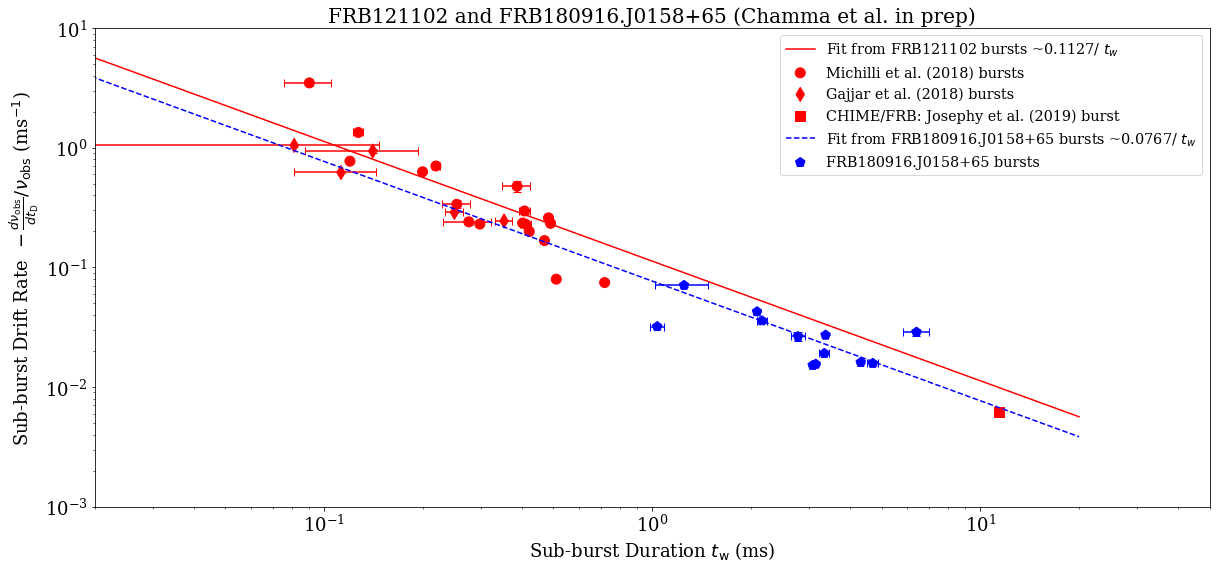

In [34]:
# michili fit
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration_inprep' if logscale else 'drift_over_nu_obsvsduration_inprep'
figsize = (17, 8)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error'], 
                               yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_error'], 
                               yerr=selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='FRB180916.J0158+65 bursts')
# selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
#                                xerr=selectbursts180814['red_chisq']*selectbursts180814['tau_w_error'], 
#                                yerr=selectbursts180814['red_chisq']*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'], 
#                                figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X',
#                                label='180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error'], 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error'], 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180814.iterrows():
#     ax.annotate(k.split('burst')[1], (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.02, 50)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,-\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}} / \\nu_\\mathrm{obs}$ (ms$^{-1}$)', size=fontsize)

# ODR fit log
num_to_fit = 24 #23 to exlude chime
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(num_to_fit)['tau_w_ms']), 
                             np.log(selectbursts121102.head(num_to_fit)['drift_over_nuobs']),
                             sx=np.log(selectbursts121102.head(num_to_fit)['red_chisq']*selectbursts121102.head(num_to_fit)['tau_w_error']), 
                             sy=np.log(selectbursts121102.head(num_to_fit)['red_chisq']*selectbursts121102.head(num_to_fit)['drift error (mhz/ms)']/selectbursts121102.head(num_to_fit)['center_f']))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms_z']), 
                             np.log(selectbursts180916['drift_z']),
                             sx=np.log(selectbursts180916['red_chisq']*selectbursts180916['tau_w_error']/(1+selectbursts180916['z'])), 
                             sy=np.log(selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']*(1+selectbursts180916['z'])/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta)]
errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta)]
names = ['Fit from FRB121102 bursts', 'Fit from FRB180916.J0158+65 bursts']
ls    = ['r-', 'b--']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    plt.plot(x, opt[0]/x, l, label=name + ' ~' + str((round(opt[0], 4))) + '/ $t_w$')

handles, labels = ax.get_legend_handles_labels()
# handles = handles [1:] + [handles[0]]
# labels = labels [1:] + [labels[0]]
handles = [handles[0], handles[2], handles[4], handles[5], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[4], labels[5], labels[1], labels[3]]
# handles = [handles[0], handles[2], handles[]]
plt.legend(handles, labels, fontsize='x-large')


# plt.title("Non Redshift Corrected", size=20)
plt.title("FRB121102 and FRB180916.J0158+65 (Chamma et al. in prep)", size=20)
plt.tight_layout()

for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))
# for f in ['png']: plt.savefig('figures/{}.{}'.format(filename, f))

# Redshift Corrected #1

To correct for redshift we scale 
### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}} \times \nu_{obs}^{-1} \times (1+z)$ and $t_w \,/\, (1+z)$

[0.11268937] [1.10537786]
[0.08308561] [1.42894252]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


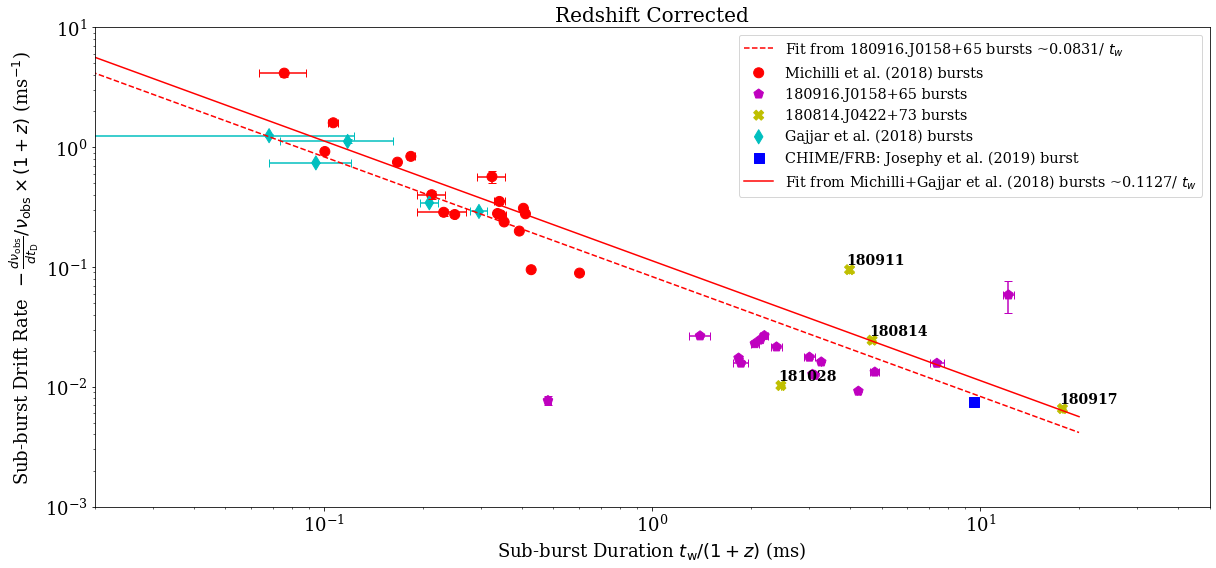

In [11]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = True
filename = 'log_drift_z_vsduration' if logscale else 'drift_z_vsduration'
figsize = (17, 8)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms_z', y='drift_z', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z']),
                               yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z'])/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_error']/(1+selectbursts180916['z']), 
                               yerr=selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']*(1+selectbursts180916['z'])/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z', 
                               xerr=selectbursts180814['red_chisq']*selectbursts180814['tau_w_error']/(1+selectbursts180814['z']), 
                               yerr=selectbursts180814['red_chisq']*selectbursts180814['drift error (mhz/ms)']*(1+selectbursts180814['z'])/selectbursts180814['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X',
                               label='180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']*(1+otherbursts['z'])/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']*(1+otherbursts['z'])/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms_z'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in selectbursts180814.iterrows():
    ax.annotate(k.split('burst')[1], (v['tau_w_ms_z'], v['drift_z']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.02, 50)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w} / (1+z)$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,-\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}} / \\nu_\\mathrm{obs} \\times (1+z)$ (ms$^{-1}$)', size=fontsize)


# ODR fit log
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(23)['tau_w_ms_z']), 
                             np.log(selectbursts121102.head(23)['drift_z']),
                             sx=np.log(selectbursts121102.head(23)['red_chisq']*selectbursts121102.head(23)['tau_w_error']/(1+selectbursts121102.head(23)['z'])), 
                             sy=np.log(selectbursts121102.head(23)['red_chisq']*selectbursts121102.head(23)['drift error (mhz/ms)']*(1+selectbursts121102.head(23)['z'])/selectbursts121102.head(23)['center_f'] ))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms_z']), 
                             np.log(selectbursts180916['drift_z']),
                             sx=np.log(selectbursts180916['red_chisq']*selectbursts180916['tau_w_error']/(1+selectbursts180916['z'])), 
                             sy=np.log(selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']*(1+selectbursts180916['z'])/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta)]
errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta)]
names = ['Fit from Michilli+Gajjar et al. (2018) bursts', 'Fit from 180916.J0158+65 bursts']
ls    = ['r-', 'r--']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    plt.plot(x, opt[0]/x, l, label=name + ' ~' + str((round(opt[0], 4))) + '/ $t_w$')

# plt.plot(x, odrfit.beta[0]/x, 'b-', label='6. x and y error \t\t${:.2f} \pm {:.2f}$'.format(odrfit.beta[0], odrfit.sd_beta[0])+'/$t_w$')

# a = np.exp(popt_log_log[1])
# k = popt_log_log[0]
# plt.plot(x, a * x**k, 'r-', label='loglog \t\t\t\t\t${:.2f}~t_w^{{{:.2f}}}$'.format(a,k))

handles, labels = ax.get_legend_handles_labels()
handles = handles [1:] + [handles[0]]
labels = labels [1:] + [labels[0]]
plt.legend(handles, labels, fontsize='x-large')

plt.title("Redshift Corrected", size=20)
plt.tight_layout()

# for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))

# Redshift Corrected #2

To correct for redshift we correct the drifts and durations to the Michilli observing frequency and then scale 
### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}} \times (1+z)^2$ and $t_w \,/\, (1+z)$

[529.81643043] [1.11078483]
[234.21800614] [1.23291917]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide


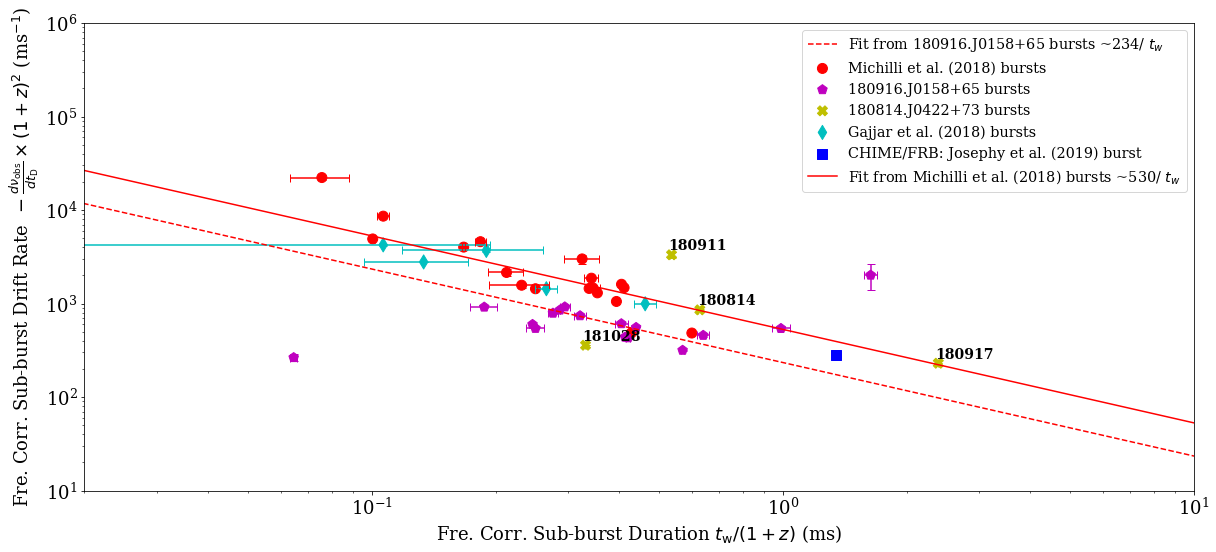

In [12]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = True
filename = 'log_drift_z_vsduration' if logscale else 'drift_z_vsduration'
figsize = (17, 8)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms_z', y='drift_z_abs', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z']),
                               yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_err_corr']/(1+selectbursts180916['z']), 
                               yerr=selectbursts180916['red_chisq']*selectbursts180916['drift_err_corr']*(1+selectbursts180916['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr', 
                               xerr=selectbursts180814['red_chisq']*selectbursts180814['tau_w_err_corr']/(1+selectbursts180814['z']), 
                               yerr=selectbursts180814['red_chisq']*selectbursts180814['drift_err_corr']*(1+selectbursts180814['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X',
                               label='180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_err_corr']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift_err_corr']*(1+otherbursts['z'])**2, 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_err_corr']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift_err_corr']*(1+otherbursts['z'])**2, 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms_z'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in selectbursts180814.iterrows():
    ax.annotate(k.split('burst')[1], (v['tau_w_ms_z_corr'], v['drift_z_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.02, 10)
    ax.set_ylim(10**1, 10**6)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Fre. Corr. Sub-burst Duration $t_\\mathrm{w} / (1+z)$ (ms)', size=fontsize)
ax.set_ylabel('Fre. Corr. Sub-burst Drift Rate $\,-\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}} \\times (1+z)^2$ (ms$^{-1}$)', size=fontsize)

# ODR fit log
fitdata_log = scipy.odr.RealData(np.log(michillibursts['tau_w_ms_z']), 
                             np.log(michillibursts['drift_z_abs']),
                             sx=np.log(michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z'])), 
                             sy=np.log(michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z']**2)))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms_z_corr']), 
                             np.log(selectbursts180916['drift_z_corr']),
                             sx=np.log(selectbursts180916['red_chisq']*selectbursts180916['tau_w_err_corr']/(1+selectbursts180916['z'])), 
                             sy=np.log(selectbursts180916['red_chisq']*selectbursts180916['drift_err_corr']*(1+selectbursts180916['z']**2)))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta)]
errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta)]
names = ['Fit from Michilli et al. (2018) bursts', 'Fit from 180916.J0158+65 bursts']
ls    = ['r-', 'r--']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    plt.plot(x, opt[0]/x, l, label=name + ' ~' + str(int(round(opt[0]))) + '/ $t_w$')

handles, labels = ax.get_legend_handles_labels()
handles = handles [1:] + [handles[0]]
labels = labels [1:] + [labels[0]]
plt.legend(handles, labels, fontsize='x-large')

plt.tight_layout()
# for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))